# Training on 25,000 events. Testing on the RAMP set.

In [1]:
!nvidia-smi

Tue Sep  5 16:22:42 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   28C    P8     9W / 180W |    235MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   29C    P8     9W / 180W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:04:00.0)


### Load in the data.

In [4]:
%%time
modelpath   = "data/models/RSKEW-10N-25T-25000E-235R.h5"
trainpath   = "data/sets/RSKEW-10N-25T-25000E-235R.gz"
testpath    = "data/sets/RAMP-10N-25T-3600E-235R.gz"
train_frame = pd.read_csv(trainpath)
test_frame  = pd.read_csv(testpath)
train       = utils.list_of_groups(train_frame, group="event_id")
test        = utils.list_of_groups(test_frame,  group="event_id")
print("Train is list of {0} events ({1} bytes).".format(len(train), sys.getsizeof(train)))
print("Test is list of {0} events ({1} bytes).".format(len(test), sys.getsizeof(test)))
if (not utils.is_prepared(train_frame)) or (not utils.is_prepared(test_frame)):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del train_frame
    del test_frame # To save on memory space.

Train is list of 25000 events (200320 bytes).
Test is list of 3600 events (30120 bytes).
CPU times: user 10.8 s, sys: 232 ms, total: 11.1 s
Wall time: 11.1 s


In [5]:
order = ["phi", "r", "z"]

### Show an example of the data.

Train 8881
Number of Hits: 125
Number of Tracks: 13


<IPython.core.display.Javascript object>


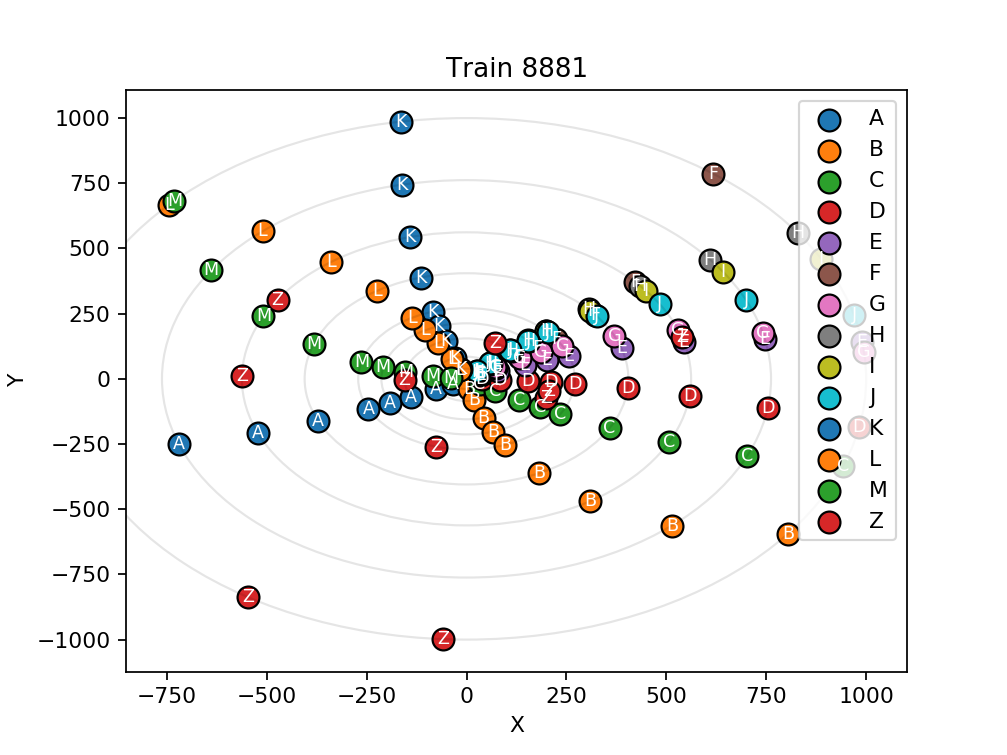

In [6]:
n = 8881 #np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [7]:
print(n)
visuals.display(train[n], order)

8881


,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-3.104504,155.0,179.016109,,,,,,,,,,,,,,,,,,,,,,,,,,1,
1,-2.808450,762.0,-124.695113,1,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-2.765921,562.0,-91.966737,1,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-2.731932,405.0,-66.274961,1,,,,,,,,,,,,,,,,,,,,,,,,,,
4,-2.703791,271.0,-44.346949,1,,,,,,,,,,,,,,,,,,,,,,,,,,
5,-2.691204,213.0,-34.855720,1,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.678875,155.0,-25.364491,1,,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.665363,85.0,-13.909560,1,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.662152,39.0,-6.382033,1,,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.149307,1000.0,-104.957190,,,,,,,,,,,,,,,,,,,,,,,,,,1,


### Create the model.

In [ ]:
input_shape  = (235, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [8]:
# If you have already created a model, run this cell to load the model.
# Else, just run the cell below this cell.
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

### Fit the model.

In [ ]:
%%time
# Current model has been trained on 68 epochs before early stopping.
epochs     = 128
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=5, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)]))

### Display information about the model after fitting it.

In [9]:
%%time
test.sort(key=lambda x: x.iloc[0]["event_id"])
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 82.49960308069295%
Percent of tracks assigned correctly: 55.787736447886246%
Percent of events with the correct number of tracks: 81.38888888888889%
CPU times: user 1min 38s, sys: 188 ms, total: 1min 39s
Wall time: 1min 39s


In [10]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

There are 400 events with 1 tracks.
There are 450 events with 2 tracks.
There are 500 events with 3 tracks.
There are 550 events with 4 tracks.
There are 600 events with 5 tracks.
There are 650 events with 6 tracks.
There are 700 events with 7 tracks.
There are 750 events with 8 tracks.
There are 800 events with 9 tracks.
There are 850 events with 10 tracks.
There are 900 events with 11 tracks.
There are 950 events with 12 tracks.
There are 1000 events with 13 tracks.
There are 1050 events with 14 tracks.
There are 1100 events with 15 tracks.
There are 1150 events with 16 tracks.
There are 1200 events with 17 tracks.
There are 1250 events with 18 tracks.
There are 1300 events with 19 tracks.
There are 1350 events with 20 tracks.
There are 1400 events with 21 tracks.
There are 1450 events with 22 tracks.
There are 1500 events with 23 tracks.
There are 1550 events with 24 tracks.
There are 1600 events with 25 tracks.


### Display how one of the model's predictions looks.

Percent of hits assigned correctly: 88.31168831168831%
Percent of tracks assigned correctly: 44.44444444444444%


<IPython.core.display.Javascript object>


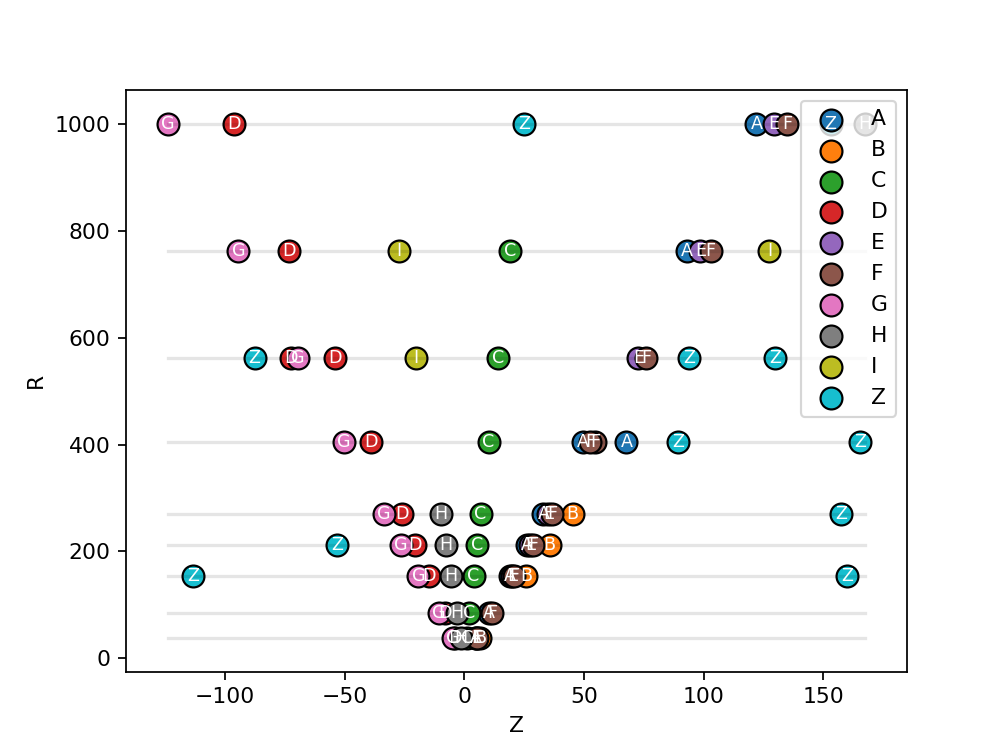

<IPython.core.display.Javascript object>


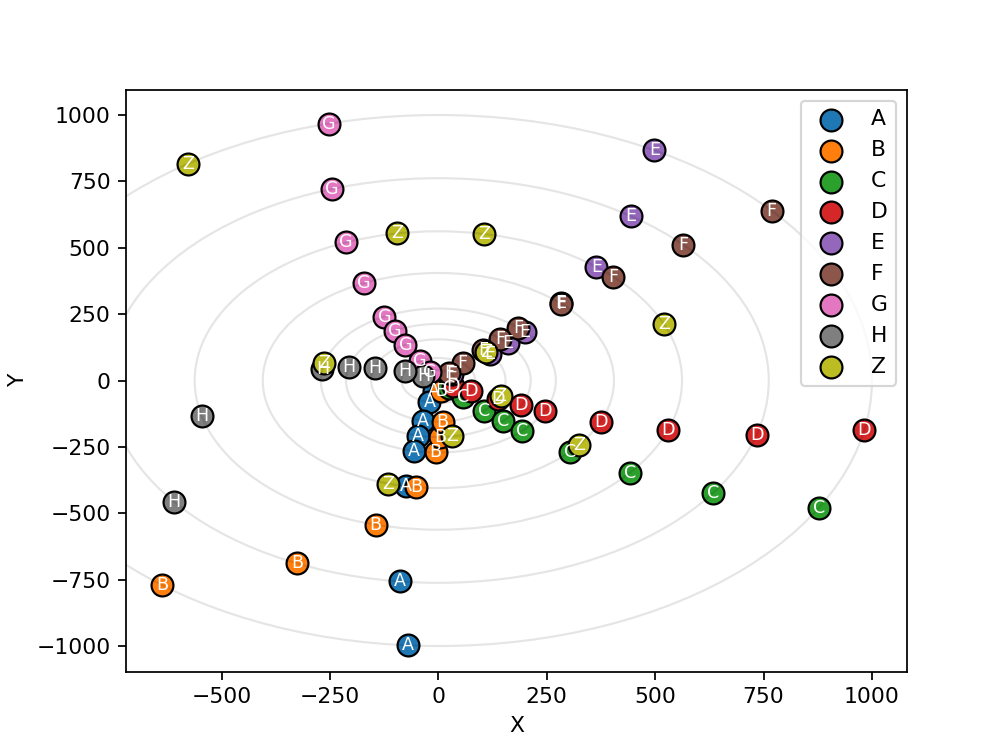

In [11]:
n = 10
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr")
_ = visuals.Plot2D(test[n], order).plot(mode="xy")

In [12]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-2.903162,562.0,-20.271684,,,,,,,,`1`[0],`0`[1],,,,,,,,,,,,,,,,,,
1,-2.498550,762.0,-27.485807,,,,,,,,`1`[0],`0`[1],,,,,,,,,,,,,,,,,,
2,-2.262245,1000.0,167.339222,,`1`[0],,,,,,`0`[1],,,,,,,,,,,,,,,,,,,
3,-2.011937,762.0,127.512487,,`1`[0],,,,,,,`0`[1],,,,,,,,,,,,,,,,,,
4,-1.861983,405.0,89.465983,,,,,,,,,,,,,,,,,,,,,,,,,,`1`[1],
5,-1.830579,562.0,94.044643,,`1`[0],,,,,,,,,,,,,,,,,,,,,,,,`0`[1],
6,-1.826880,39.0,4.760687,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
7,-1.816456,85.0,10.375856,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
8,-1.802085,155.0,18.920679,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
9,-1.790836,213.0,26.000675,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,


### Display the graphs.

<IPython.core.display.Javascript object>


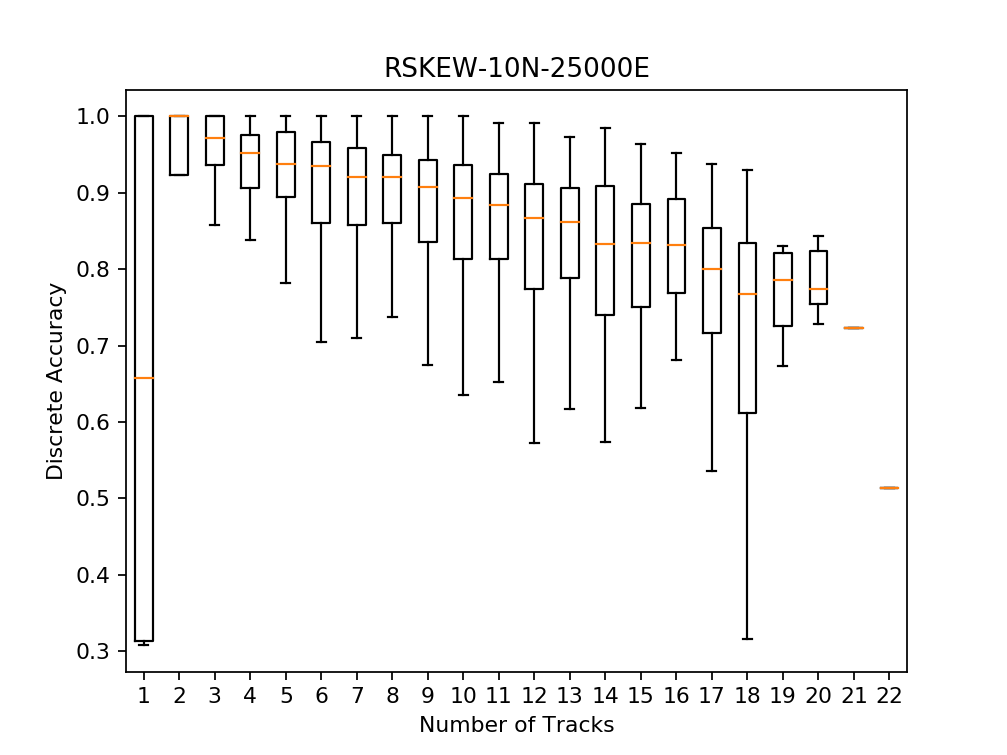

CPU times: user 29.2 s, sys: 4 ms, total: 29.2 s
Wall time: 29.2 s


In [13]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "RSKEW-10N-25000E", "Number of Tracks", "Discrete Accuracy", xticks=list(r))

<IPython.core.display.Javascript object>


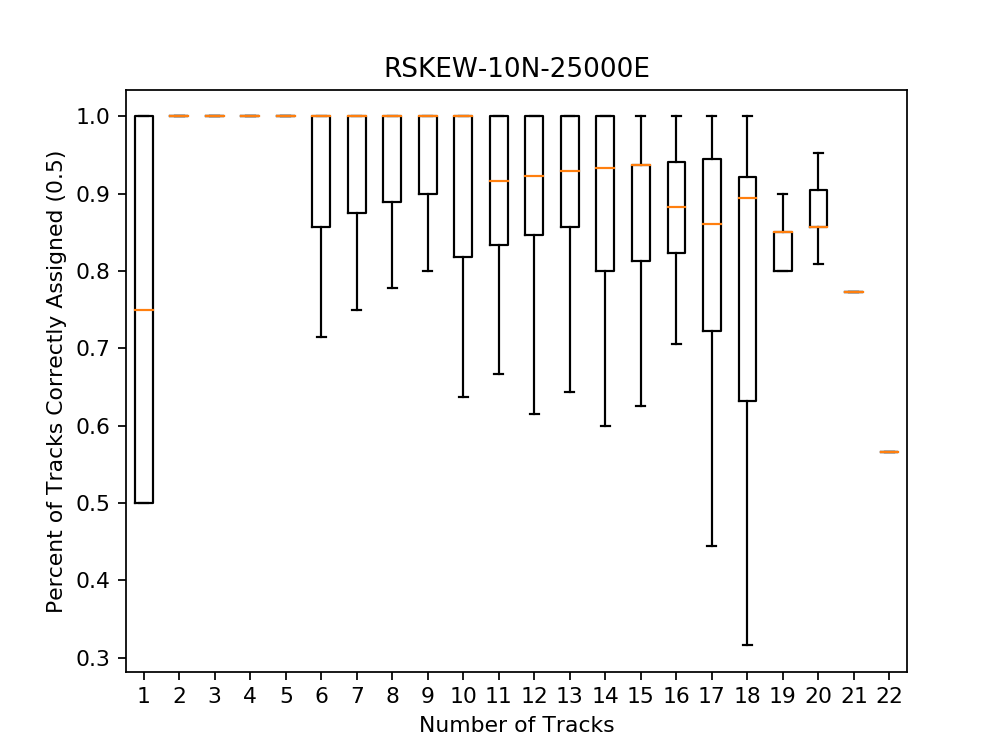

<IPython.core.display.Javascript object>


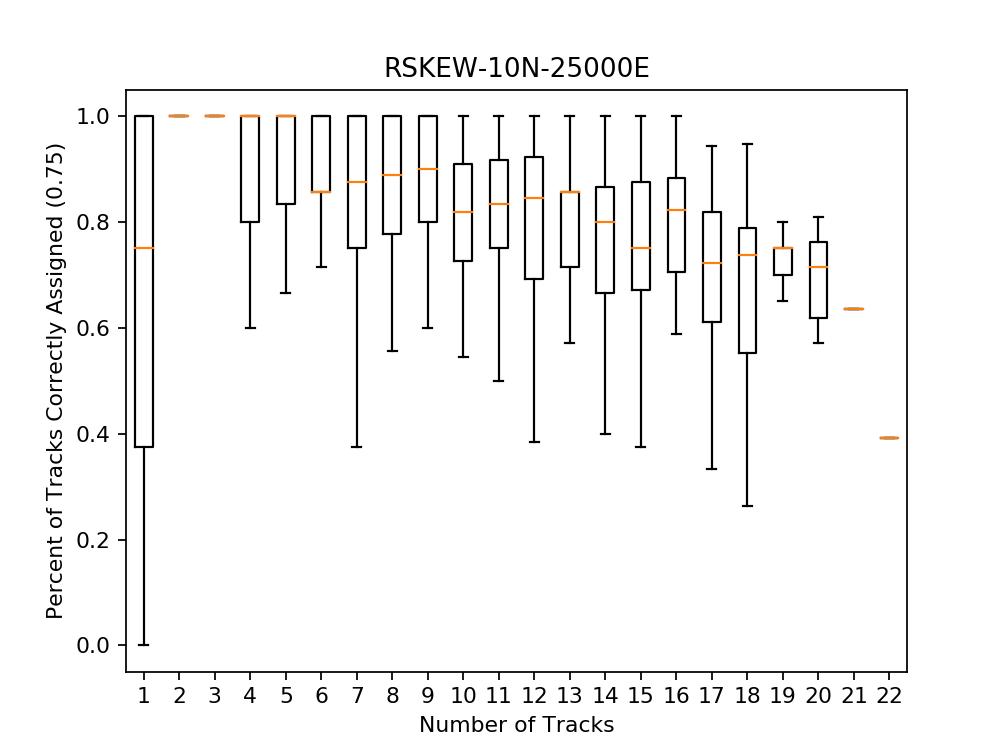

<IPython.core.display.Javascript object>


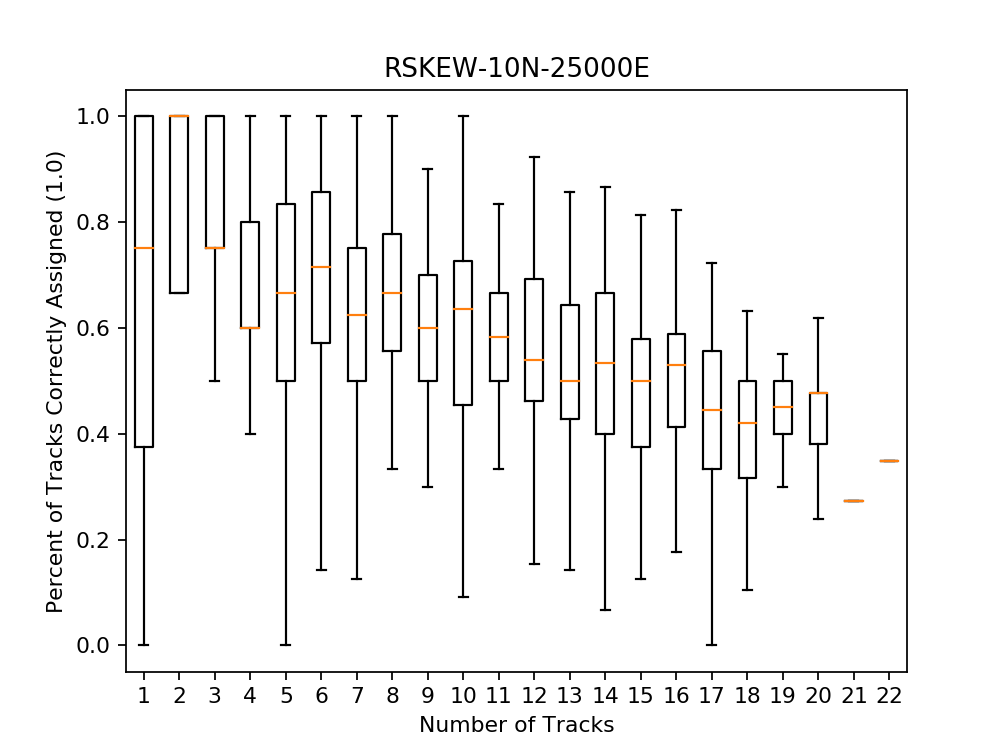

CPU times: user 2min, sys: 24 ms, total: 2min
Wall time: 2min


In [16]:
%%time
for percent in [0.5, 0.75, 1.0]:
    c_tracks = [metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order, percent=percent)
                for n in range(len(guesses))]
    boxes = [[] for _ in r]
    for i in range(len(c_tracks)):
        index = metrics.number_of_tracks(test[i]) - 1
        boxes[index].append(c_tracks[i])
    visuals.boxplot(
        boxes, "RSKEW-10N-25000E", "Number of Tracks",
        "Percent of Tracks Correctly Assigned ({})".format(percent), xticks=list(r))

<IPython.core.display.Javascript object>


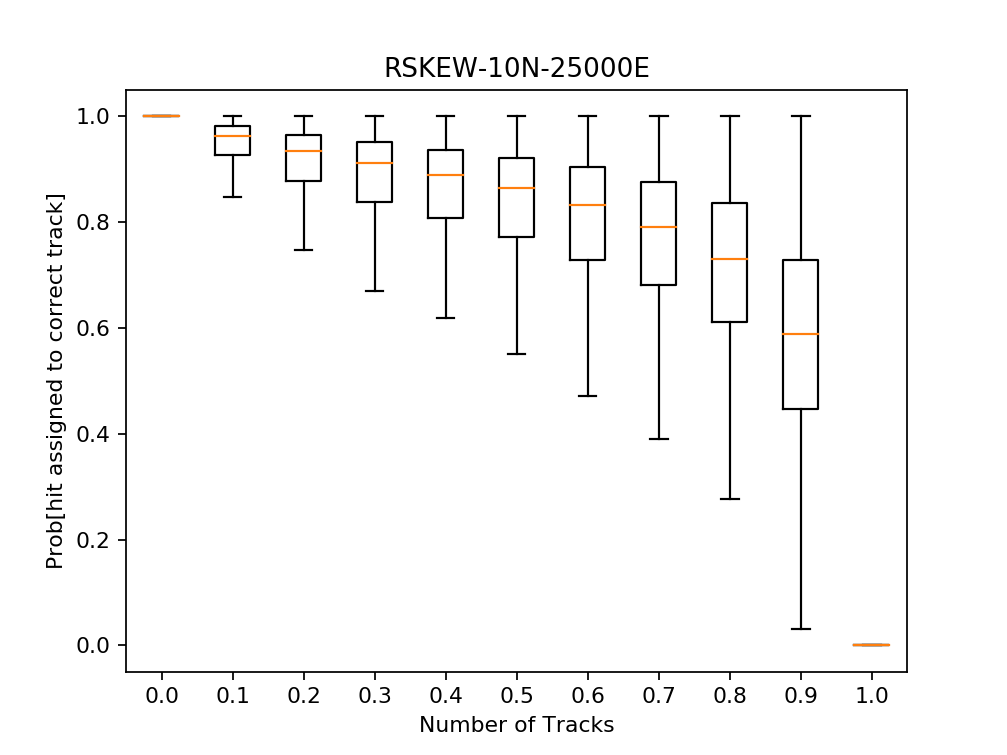

<IPython.core.display.Javascript object>


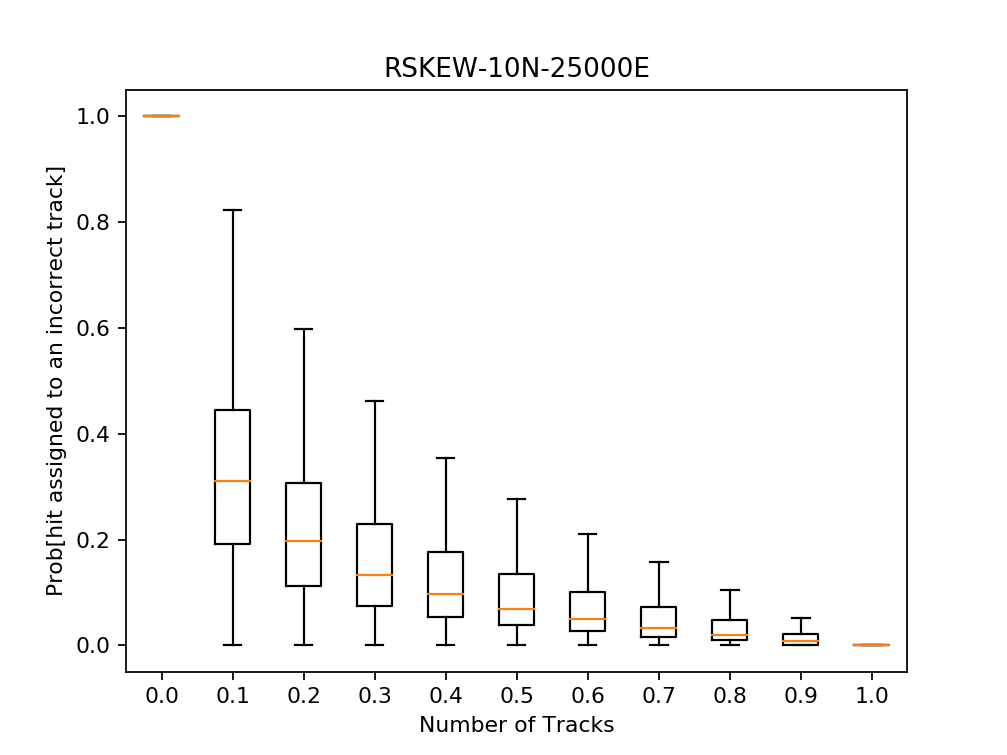

<IPython.core.display.Javascript object>


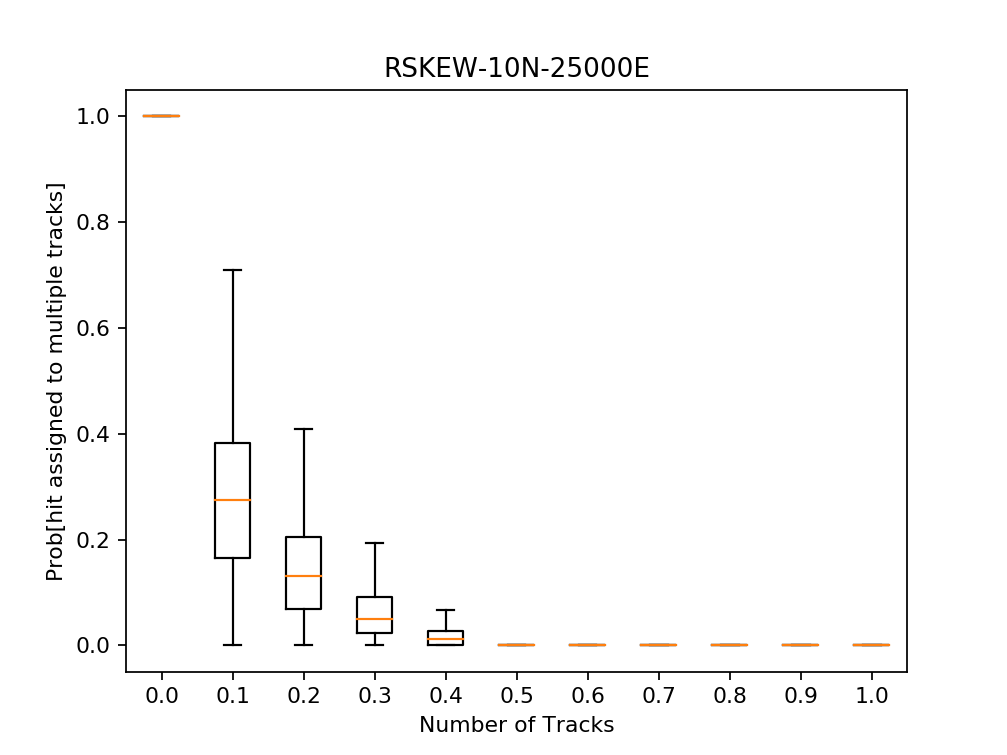

<IPython.core.display.Javascript object>


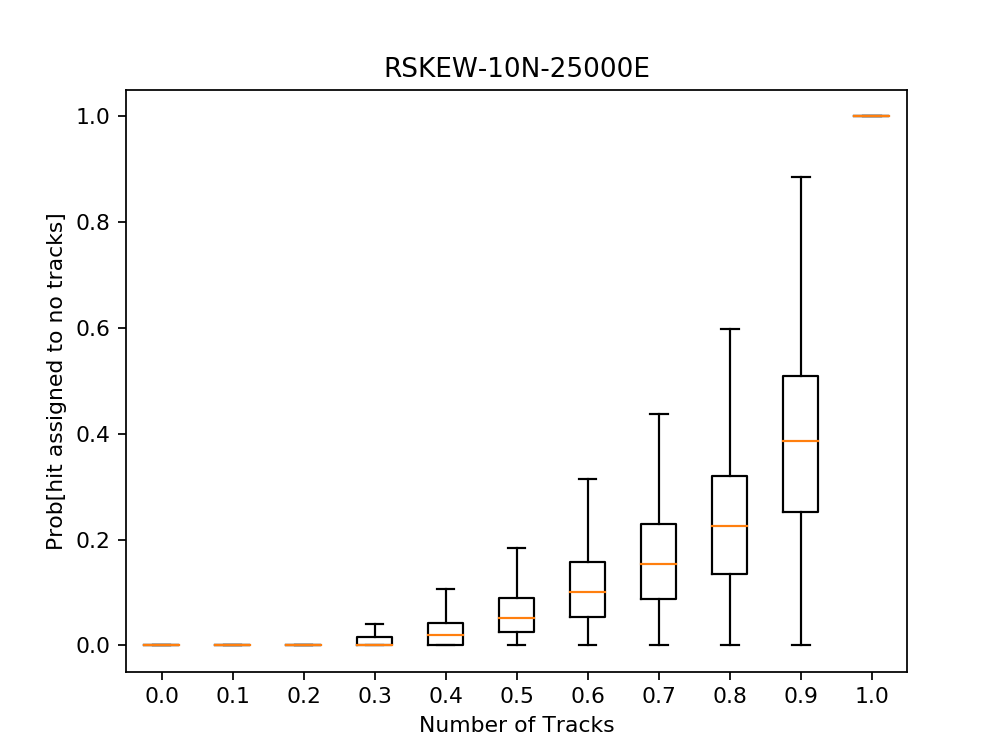

CPU times: user 4min 27s, sys: 48 ms, total: 4min 27s
Wall time: 4min 27s


In [17]:
%%time
thresholds = [i / 10 for i in range(11)]
threshold_metrics = [[metrics.threshold_metrics(test[i], guesses[i], n, order)
                      for i in range(len(guesses))] for n in thresholds]
boxes_correct   = [[m[0] for m in metric] for metric in threshold_metrics]
boxes_incorrect = [[m[1] for m in metric] for metric in threshold_metrics]
boxes_multi     = [[m[2] for m in metric] for metric in threshold_metrics]
boxes_none      = [[m[3] for m in metric] for metric in threshold_metrics]
visuals.boxplot(
    boxes_correct, 
    "RSKEW-10N-25000E", "Number of Tracks", "Prob[hit assigned to correct track]", xticks=thresholds)
visuals.boxplot(
    boxes_incorrect, 
    "RSKEW-10N-25000E", "Number of Tracks", "Prob[hit assigned to an incorrect track]", xticks=thresholds)
visuals.boxplot(
    boxes_multi, 
    "RSKEW-10N-25000E", "Number of Tracks", "Prob[hit assigned to multiple tracks]", xticks=thresholds)
visuals.boxplot(
    boxes_none, 
    "RSKEW-10N-25000E", "Number of Tracks", "Prob[hit assigned to no tracks]", xticks=thresholds)